# Problem Statement and Business Understanding
<div style="font-family: Arial; list-style-type: none; background-color: #52BC77; padding: 10px; border-radius: 10px; color: white;">
<p>💡
    A bank is facing an increasing number of defaults on loans, and needs to improve its credit risk modeling in order to better predict which customers are likely to default on their loans in the future.</p>
<p>    
📑
    The bank needs to identify customers who are at high risk of defaulting on their loans in order to take appropriate action, such as increasing the interest rate on the loan or declining the loan application. This will help the bank reduce its overall risk and increase its profitability. 
    </p>
<p>📈
    By accurately identifying high-risk customers, the bank can also improve its customer relationships by being more transparent about the terms of the loan. Additionally, the bank can use the results of the credit risk modeling to inform its marketing and sales strategies, targeting higher-risk customers with more appropriate products and services.
    </p>
    <p>
🎯
The goal is to accurately identify high-risk loans in order to take appropriate action, such as increasing the interest rate on the loan or declining the loan application, which will help the bank reduce its overall risk and increase its profitability.
    </p></div>

In [1]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
!pip freeze > requirements.txt

In [3]:
!pip install category_encoders

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, plot_roc_curve, confusion_matrix
from ipywidgets import interact, FloatSlider
from ipywidgets import Play, jslink, HBox, interactive_output
from IPython.display import display
import warnings
import pickle

In [5]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_style('dark')

In [6]:
df = pd.read_csv("loan_data_2015 (1).csv", encoding="ISO-8859-1")

df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,60516983,64537751,20000,20000,20000,36 months,12.29,667.06,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,41000,NaN,NaN,NaN
1,60187139,64163931,11000,11000,11000,36 months,12.69,369.00,C,C2,...,NaN,NaN,NaN,NaN,NaN,NaN,13100,NaN,NaN,NaN
2,60356453,64333218,7000,7000,7000,36 months,9.99,225.84,B,B3,...,NaN,NaN,NaN,NaN,NaN,NaN,16300,NaN,NaN,NaN
3,59955769,63900496,10000,10000,10000,36 months,10.99,327.34,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,34750,NaN,NaN,NaN
4,58703693,62544456,9550,9550,9550,36 months,19.99,354.87,E,E4,...,NaN,NaN,NaN,NaN,NaN,NaN,14100,NaN,NaN,NaN


# EDA and Feature Engineering

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421094 entries, 0 to 421093
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           421094 non-null  int64  
 1   member_id                    421094 non-null  int64  
 2   loan_amnt                    421094 non-null  int64  
 3   funded_amnt                  421094 non-null  int64  
 4   funded_amnt_inv              421094 non-null  int64  
 5   term                         421094 non-null  object 
 6   int_rate                     421094 non-null  float64
 7   installment                  421094 non-null  float64
 8   grade                        421094 non-null  object 
 9   sub_grade                    421094 non-null  object 
 10  emp_title                    397220 non-null  object 
 11  emp_length                   397277 non-null  object 
 12  home_ownership               421094 non-null  object 
 13 

In [8]:
def missing_pct(df):
    selected_features = []
    for col in df.columns:
        missing = np.ceil(df[col].isna().sum() / len(df) * 100)
        print(f"Total Missing Values of {col} feature is: {missing} %")
        if missing < 50:
            selected_features.append(col)
            
    return selected_features

In [9]:
feats = missing_pct(df)

Total Missing Values of id feature is: 0.0 %
Total Missing Values of member_id feature is: 0.0 %
Total Missing Values of loan_amnt feature is: 0.0 %
Total Missing Values of funded_amnt feature is: 0.0 %
Total Missing Values of funded_amnt_inv feature is: 0.0 %
Total Missing Values of term feature is: 0.0 %
Total Missing Values of int_rate feature is: 0.0 %
Total Missing Values of installment feature is: 0.0 %
Total Missing Values of grade feature is: 0.0 %
Total Missing Values of sub_grade feature is: 0.0 %
Total Missing Values of emp_title feature is: 6.0 %
Total Missing Values of emp_length feature is: 6.0 %
Total Missing Values of home_ownership feature is: 0.0 %
Total Missing Values of annual_inc feature is: 0.0 %
Total Missing Values of verification_status feature is: 0.0 %
Total Missing Values of issue_d feature is: 0.0 %
Total Missing Values of loan_status feature is: 0.0 %
Total Missing Values of pymnt_plan feature is: 0.0 %
Total Missing Values of url feature is: 0.0 %
Total M

In [10]:
len(feats)

54

In [11]:
df = df[feats]

## Identifying Target Column

In [12]:
df['loan_status'].value_counts()

Current               377553
Fully Paid             22984
Issued                  8460
Late (31-120 days)      4691
In Grace Period         3107
Charged Off             2773
Late (16-30 days)       1139
Default                  387
Name: loan_status, dtype: int64

<div style="font-family: Arial; list-style-type: none; background-color: #E27E39; padding: 10px; border-radius: 10px; color: white;">
    I will be including the following loan statuses from our analysis, as non-risky:
<ul><li>🐬
<b> Fully Paid </b> : refers to the people who have already paid off the loan and are non-risky.</li></ul>
    I will consider the following loan statuses as risky:
<ul><li>🐬
<b> Charged off</b> : means the borrower has been deemed incapable of paying the loan and it will be marked under NPA(Non Performing Asset).</li>
    <li>🐬<b> Default</b> : means the borrower has not paid his/her loan even after 120 days.</li>
    <li>🐬
<b>Late (31-120 days) </b> : means that the borrower has not paid the amount on time and there is a delay in payment of more than 31 days, this label comes under risky loan.</li></ul>
I will also be excluding the following loan statuses from our analysis, as they can go both ways:
<ul>
    <li>
<b> 
    🐬 Current</b> : refers to the current loan cycle, but there is a probability that they might default in future.</li><li>
<b> 🐬 In Grace Period </b> : means the borrower has delayed his payment by 1-15 days, this comes under non-risky loan, but if the borrower does not pay, it becomes risky. Since we cannot say whether the borrower will default or not as of yet, this category  won't be used for the analysis.</li><li>
<b> 🐬 Late(16-30 days)</b> : means that the borrower has delayed his payments by 16-30 days, this can also go both ways, so we are not going to use this label in our analysis.</li>
    <li>🐬
<b> Issued </b> : refers to the loan has been issued just and the payment cycle has not begun, but there is a probability that the borrower may default in future.</li></ul>  
    </div>

In [13]:
mask = (df['loan_status'] != 'Current') & (df['loan_status'] != 'Issued') & (df['loan_status'] != 'Late (16-30 days)') & (df['loan_status'] != 'In Grace Period')
df = df[mask]
df['risk'] = np.where((df['loan_status'] == 'Charged Off') | (df['loan_status'] == 'Late (31-120 days)') | (df['loan_status'] == 'Default'), 1, 0)

In [14]:
df.drop('loan_status', axis=1, inplace=True)

In [15]:
df.shape

(30835, 54)

## Cleaning Categorical Columns

In [16]:
cat_cols = df.select_dtypes('object').columns
for col in cat_cols:
    print(col, df[col].nunique())

term 2
grade 7
sub_grade 35
emp_title 14408
emp_length 11
home_ownership 3
verification_status 3
issue_d 12
pymnt_plan 1
url 30835
purpose 13
title 13
zip_code 837
addr_state 49
earliest_cr_line 560
initial_list_status 2
last_pymnt_d 13
next_pymnt_d 2
last_credit_pull_d 14
application_type 2


In [17]:
df.emp_title.value_counts()

Manager                          511
Teacher                          446
Supervisor                       233
Registered Nurse                 206
Sales                            200
                                ... 
Tracher                            1
Sturtuce Assembly                  1
director business development      1
Data Warehouse Analyst             1
Elementary School Teacher          1
Name: emp_title, Length: 14408, dtype: int64

In [18]:
df.emp_length.value_counts()

10+ years    10311
2 years       2804
< 1 year      2575
3 years       2389
1 year        2070
4 years       1818
5 years       1769
8 years       1540
7 years       1447
6 years       1329
9 years       1218
Name: emp_length, dtype: int64

In [19]:
df.home_ownership.value_counts()

MORTGAGE    14848
RENT        12488
OWN          3499
Name: home_ownership, dtype: int64

In [20]:
df.verification_status.value_counts()

Source Verified    12890
Verified           10010
Not Verified        7935
Name: verification_status, dtype: int64

In [21]:
df.purpose.value_counts()

debt_consolidation    19354
credit_card            5324
home_improvement       2028
other                  1726
major_purchase          658
small_business          350
medical                 346
car                     292
moving                  283
house                   231
vacation                218
renewable_energy         23
wedding                   2
Name: purpose, dtype: int64

In [22]:
df.title.value_counts()

Debt consolidation         19348
Credit card refinancing     5333
Home improvement            2028
Other                       1726
Major purchase               657
Business                     349
Medical expenses             346
Car financing                292
Moving and relocation        283
Home buying                  231
Vacation                     218
Green loan                    23
Credit Card/Auto Repair        1
Name: title, dtype: int64

In [23]:
df.initial_list_status.value_counts()

w    16070
f    14765
Name: initial_list_status, dtype: int64

In [24]:
df.application_type.value_counts()

INDIVIDUAL    30832
JOINT             3
Name: application_type, dtype: int64

<ul style="font-family: Arial; list-style-type: none; background-color: #BCB152; padding: 10px; border-radius: 3px; color: white;">
  <li>🐬 The Sub Grade column has 35 categorical values which may not be useful, as they would increase the complexity of the dataset and machine learning model. </li>
  <li>🐬 The Employee title column has many categories, it's not useful and should be dropped. </li>
  <li>🐬 The Emp Length column needs to be reformatted as it contains string values instead of numerical values. </li>
  <li>🐬 The Issue_d column is not relevant to the problem and should be dropped. </li>
  <li>🐬 The Payment plan and url columns are not useful, they should be dropped. </li>
  <li>🐬 The Title and Purpose columns are similar and one of them should be dropped. </li>
  <li>🐬 The Zip Code, Address state, and earliest_cr_line columns have high cardinality and should be dropped. </li>
  <li>🐬 The Last payment date, next payment date, and last credit pull date columns have no relation to the default prediction and should be dropped. </li>
  <li>🐬 The Application type column can be dropped as it has no useful information. </li>
</ul>


In [25]:
df['emp_len'] = df.emp_length.str.findall('([0-9]+)')
df['emp_len'] = df.emp_len.apply(lambda x: float(x[0]) if x is not np.nan else np.nan)

In [26]:
df['emp_len'].value_counts()

10.0    10311
1.0      4645
2.0      2804
3.0      2389
4.0      1818
5.0      1769
8.0      1540
7.0      1447
6.0      1329
9.0      1218
Name: emp_len, dtype: int64

## Numerical Columns

In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30835.0,4.712025e+07,8.007436e+06,70000.00,4.050251e+07,45414411.00,5.282388e+07,6.860466e+07
member_id,30835.0,5.033249e+07,8.491318e+06,275408.00,4.336657e+07,48502224.00,5.631870e+07,7.350742e+07
loan_amnt,30835.0,1.465984e+04,8.785060e+03,1000.00,8.000000e+03,12525.00,2.000000e+04,3.500000e+04
funded_amnt,30835.0,1.465984e+04,8.785060e+03,1000.00,8.000000e+03,12525.00,2.000000e+04,3.500000e+04
funded_amnt_inv,30835.0,1.465529e+04,8.782062e+03,1000.00,8.000000e+03,12525.00,2.000000e+04,3.500000e+04
int_rate,30835.0,1.411772e+01,4.638462e+00,5.32,1.099000e+01,13.66,1.714000e+01,2.899000e+01
installment,30835.0,4.380417e+02,2.574182e+02,30.88,2.516100e+02,377.09,5.787900e+02,1.424570e+03
annual_inc,30835.0,7.598086e+04,7.923038e+04,4524.00,4.520250e+04,65000.00,9.000000e+04,8.706582e+06
dti,30835.0,1.858149e+01,8.735470e+00,0.00,1.199000e+01,18.00,2.475000e+01,5.714000e+01
delinq_2yrs,30835.0,3.293660e-01,9.044111e-01,0.00,0.000000e+00,0.00,0.000000e+00,2.000000e+01


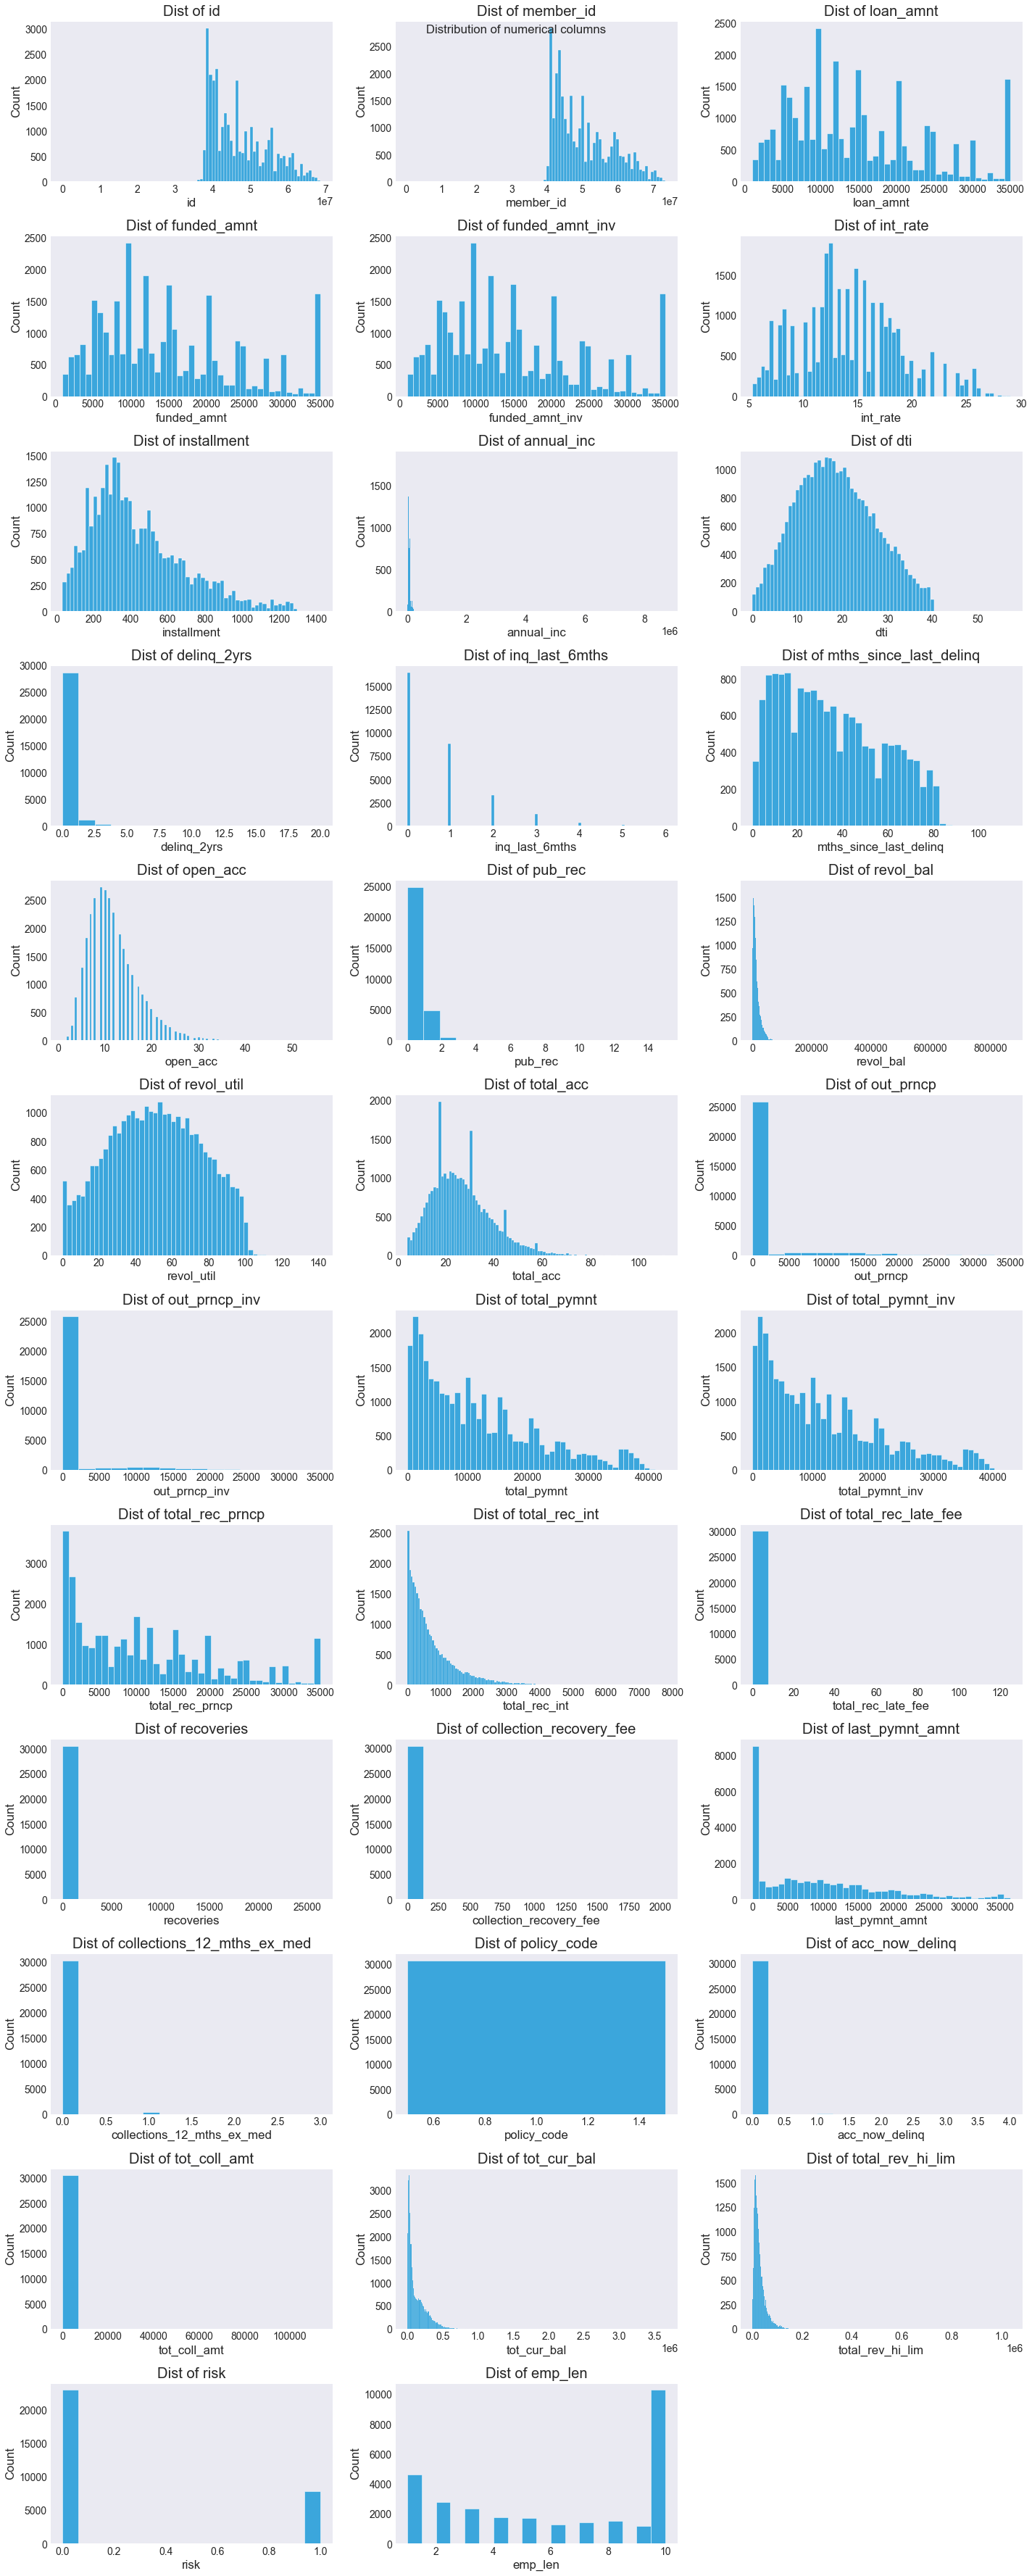

In [28]:
num_cols = df.select_dtypes('number').columns
plt.figure(figsize=(20, 50))
for i in range(len(num_cols)):
    plt.subplot(12, 3, i + 1)
    sns.histplot(data=df, x=num_cols[i])
    plt.title(f'Dist of {num_cols[i]}')

plt.suptitle('Distribution of numerical columns')
plt.tight_layout();

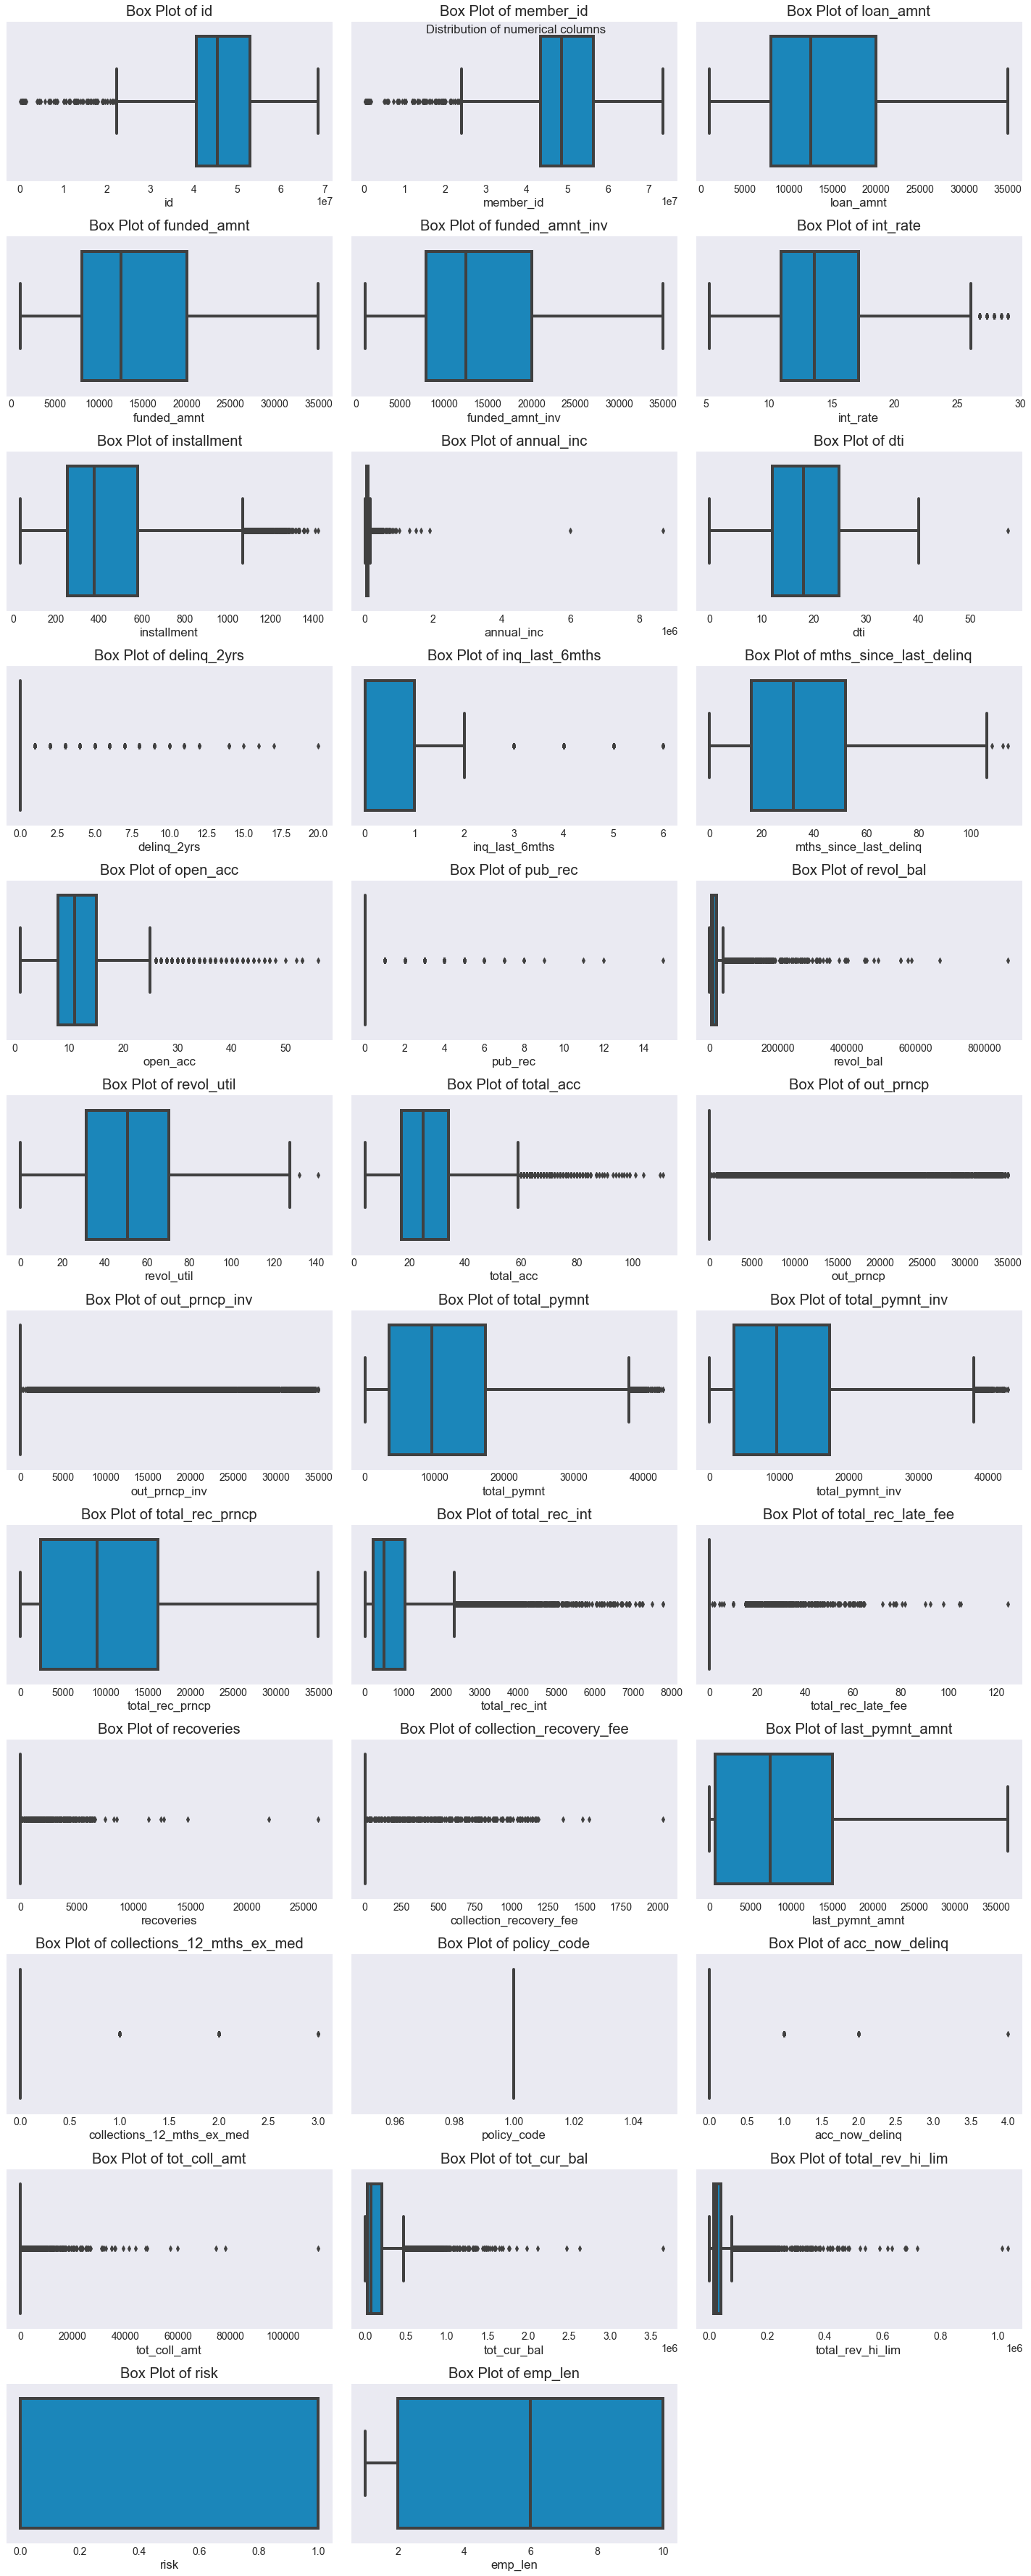

In [29]:
num_cols = df.select_dtypes('number').columns
plt.figure(figsize=(20, 50))
for i in range(len(num_cols)):
    plt.subplot(12, 3, i + 1)
    sns.boxplot(data=df, x=num_cols[i])
    plt.title(f'Box Plot of {num_cols[i]}')

plt.suptitle('Distribution of numerical columns')
plt.tight_layout();

<ul style="font-family: Arial; list-style-type: none; background-color: #BC528C; padding: 10px; border-radius: 10px; color: white;">
  <li>🐋 The columns delinq_2yrs, inq_last_6mths, pub_rec, out_prncp, out_prncp_inv, total_rec_late_fee, recoveries, collection_recovery_fee, policy_code, collections_12_mths_ex_med, acc_now_delinq, and tot_coll_amt have mostly zeroes which could make it difficult to predict the default. </li>
  <li>🐋 Some outliers from the columns open_acc, revol_balance, total_acc, total_rec_int, tot_cur_balance, and total_rev_hi_lim could be removed. </li>
</ul>

In [30]:
def clip(series):
    first, second, third, high = series.quantile([0.25, 0.5, 0.75, 0.99])
    return np.where(series > high, high, series)

clip(df['total_rev_hi_lim'])

array([ 41000.,  13100.,  16300., ...,   7200., 159798.,  43500.])

### Dealing with Multicollinearity

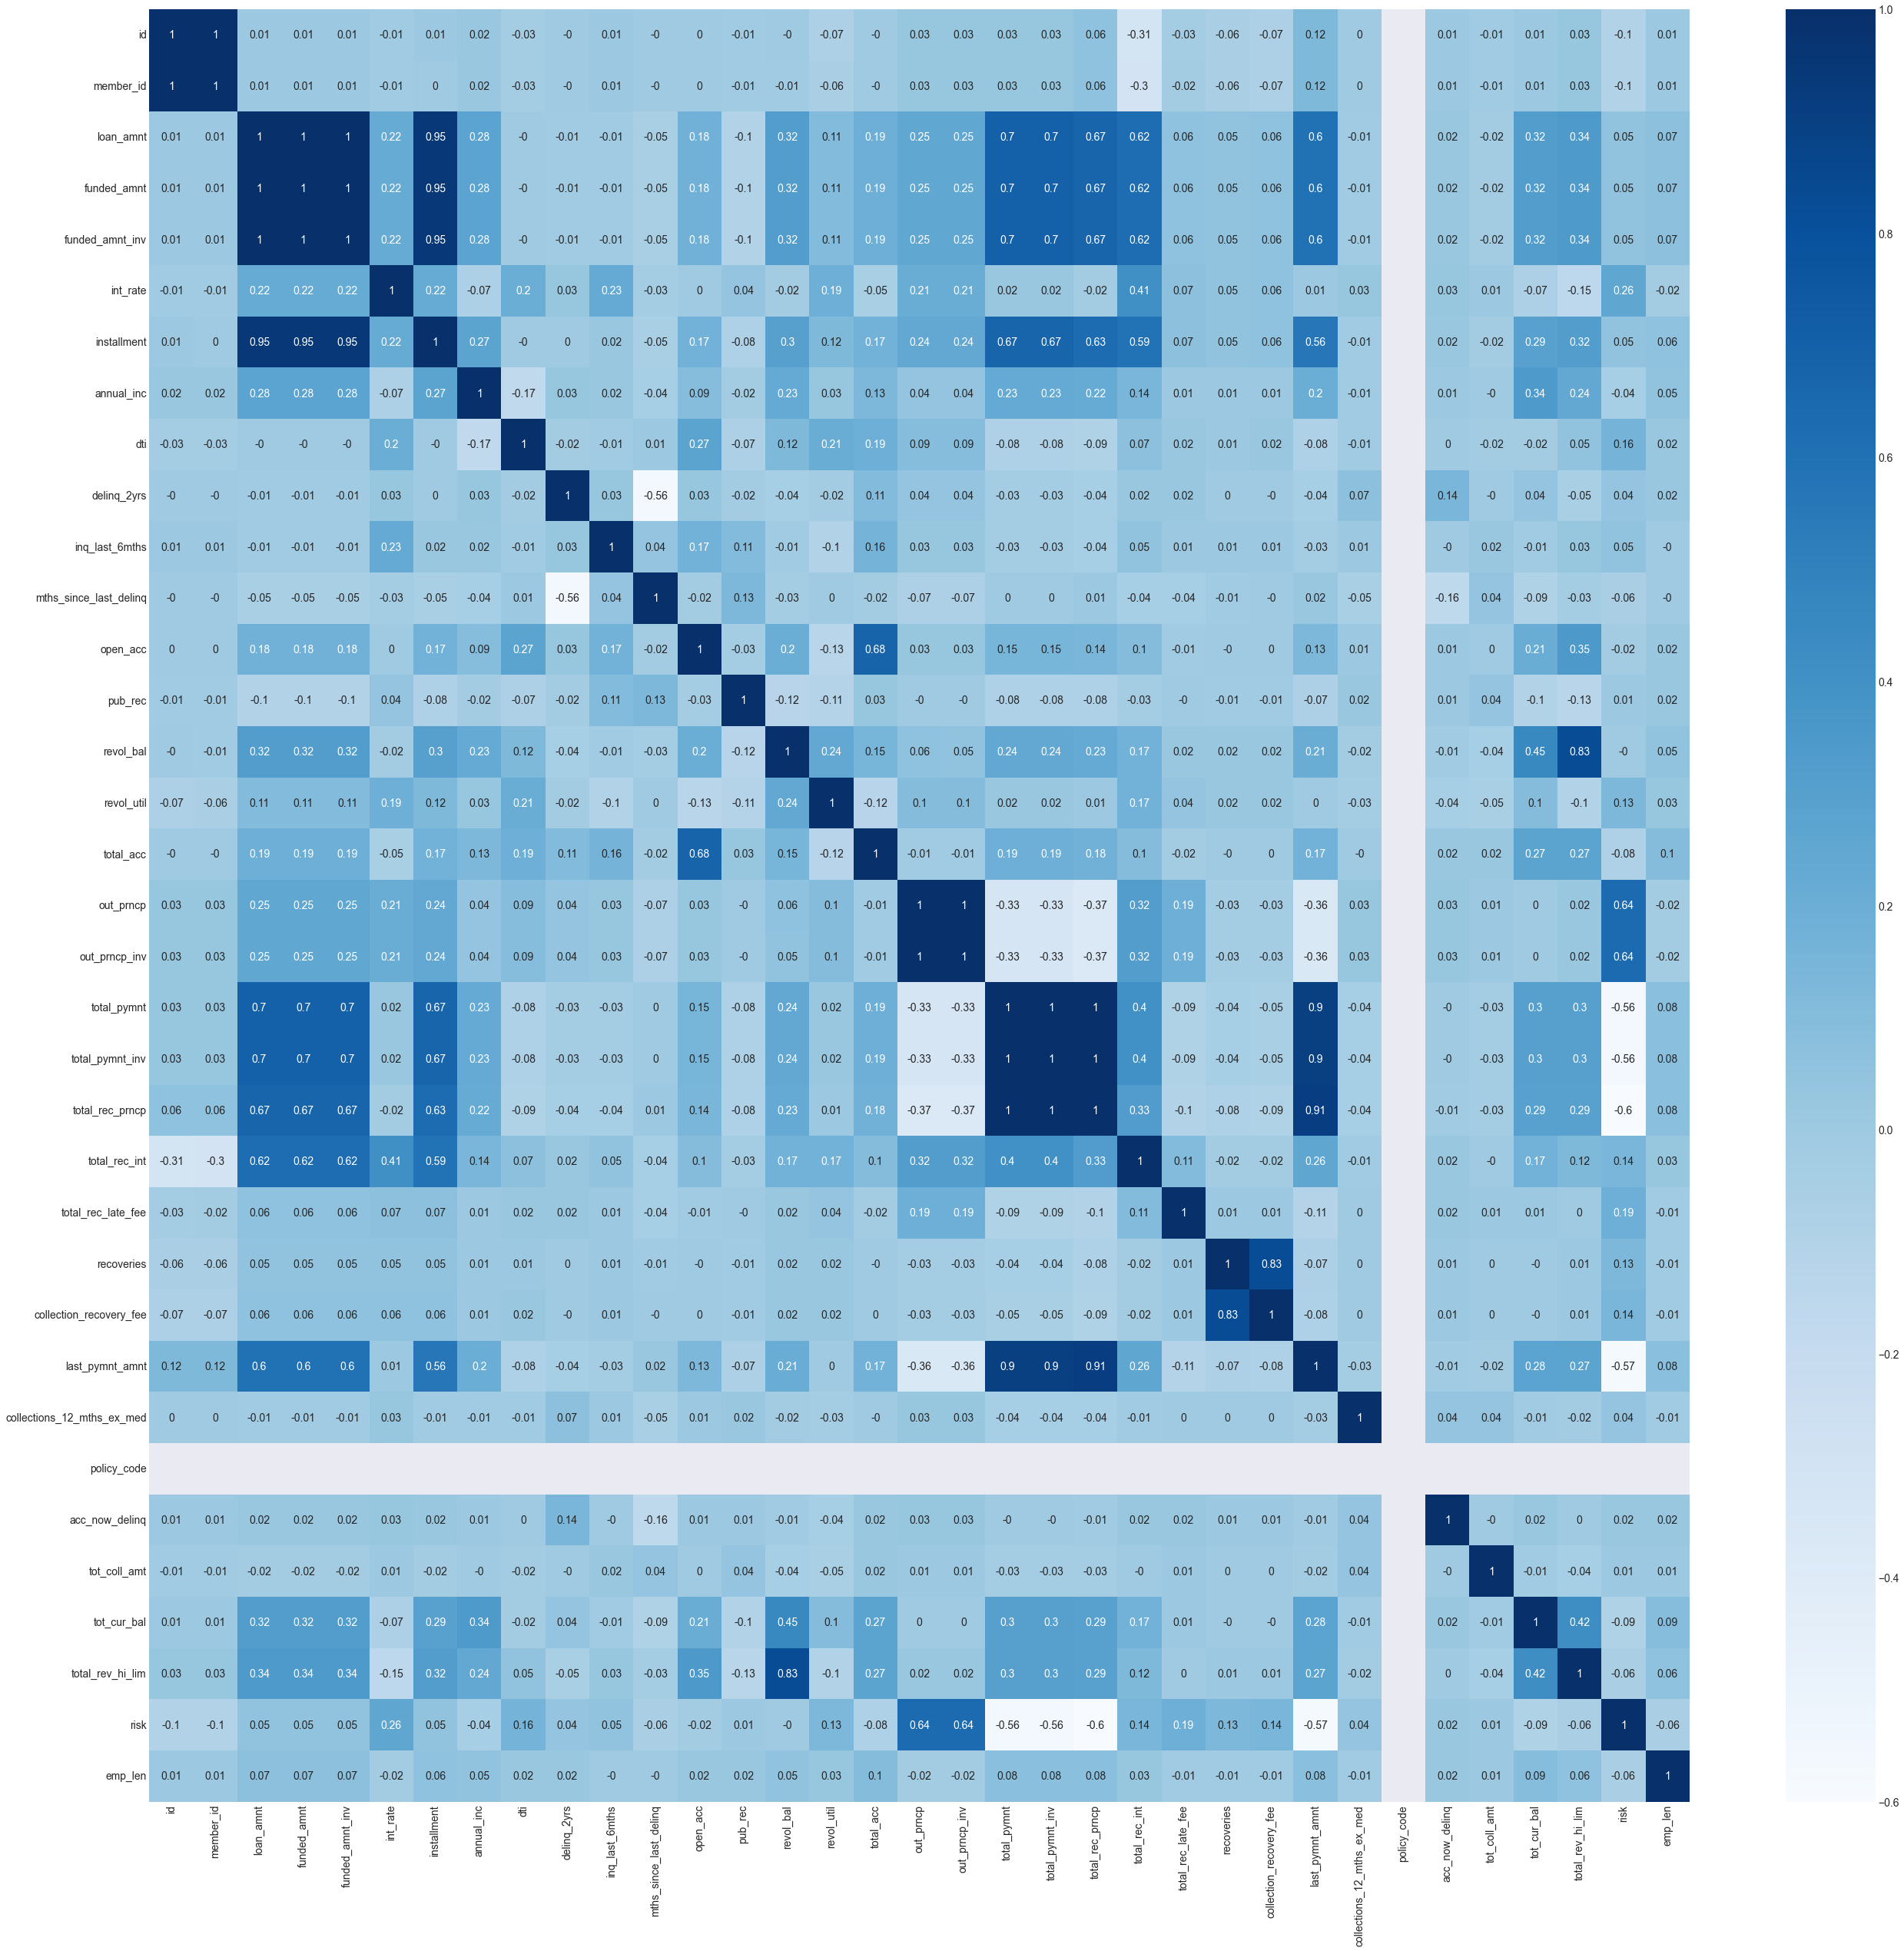

In [31]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr().round(2), annot=True, cmap="Blues");

In [32]:
corr = df.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.90)]
drop

['member_id',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'out_prncp_inv',
 'total_pymnt_inv',
 'total_rec_prncp',
 'last_pymnt_amnt']

# Putting it all together

In [33]:
def missing_pct(df):
    selected_features = []
    for col in df.columns:
        missing = np.ceil(df[col].isna().sum() / len(df) * 100)
#         print(f"Total Missing Values of {col} feature is: {missing}")
        if missing < 50:
            selected_features.append(col)
            
    return selected_features

def clip(series):
    first, second, third, high = series.quantile([0.25, 0.5, 0.75, 0.99])
    return np.where(series > high, high, series)

def wrangle(filepath):
    
    # Read the csv file into dataframe
    df = pd.read_csv(filepath, encoding="ISO-8859-1")
    
    # Find the target column and convert it to use for classification
    mask = ((df['loan_status'] != 'Current') & (df['loan_status'] != 'Issued') & 
            (df['loan_status'] != 'Late (16-30 days)') & (df['loan_status'] != 'In Grace Period'))
    df = df[mask]
    df['risk'] = np.where((df['loan_status'] == 'Charged Off') | (df['loan_status'] == 'Late (31-120 days)') | (df['loan_status'] == 'Default'), 1, 0)
    
    # Find the columns to drop
    drop_col = []
    drop_col.extend(['loan_status', 'id', 'member_id'])
    
    # Drop High and Low Cardinal Categorical Features and unimportant categorical columns
    drop_col.extend(['sub_grade', 'issue_d', 'pymnt_plan', 'url', 'purpose', 'zip_code', 'addr_state', 'emp_title',
                     'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type'])
    
    # Feature Engineering Categorical Columns
    df['emp_len'] = df.emp_length.str.findall('([0-9]+)')
    df['emp_len'] = df.emp_len.apply(lambda x: float(x[0]) if x is not np.nan else np.nan)
    drop_col.append('emp_length')
    df['term'] = df['term'].str[:3].astype(int)
    rules = (df['title'] == 'Debt consolidation') | (df['title'] == 'Credit card refinancing') | (df['title'] == 'Home improvement')
    df['title'] = np.where(rules, df['title'], 'Other')
    
    # Clipping outliers
    clip_cols = ['open_acc', 'revol_bal', 'total_acc', 'total_rec_int', 'tot_cur_bal', 'total_rev_hi_lim']
    for col in clip_cols:
        df[col] = clip(df[col])
    
    # Dropping numerical columns with very skewed distribution
    drop_col.extend(['delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 
                     'collection_recovery_fee', 'policy_code', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt'])

    # Dropping columns with multicollinearity
    corr = df.drop('risk', axis=1).corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.75)]
    drop_col.extend(drop)
    
    # Drop the columns that are not required
    df.drop(columns=drop_col, axis=1, inplace=True)

    # Find percent of missing values in each column and drop columns which has majority of missing values
    feats = missing_pct(df)
    feats
    df = df[feats]
    
    return df

In [35]:
df = wrangle("loan_data_2015 (1).csv")
df.shape

(30835, 18)

In [36]:
df.isna().sum()

loan_amnt               0
term                    0
int_rate                0
grade                   0
home_ownership          0
annual_inc              0
verification_status     0
title                   0
dti                     0
open_acc                0
revol_bal               0
revol_util             18
total_acc               0
initial_list_status     0
total_pymnt             0
total_rec_int           0
tot_cur_bal             0
risk                    0
dtype: int64

# Data Visualization

### Average Default Rate

In [37]:
avg_default_rate = df['risk'].mean()
avg_default_rate

0.2546132641478839

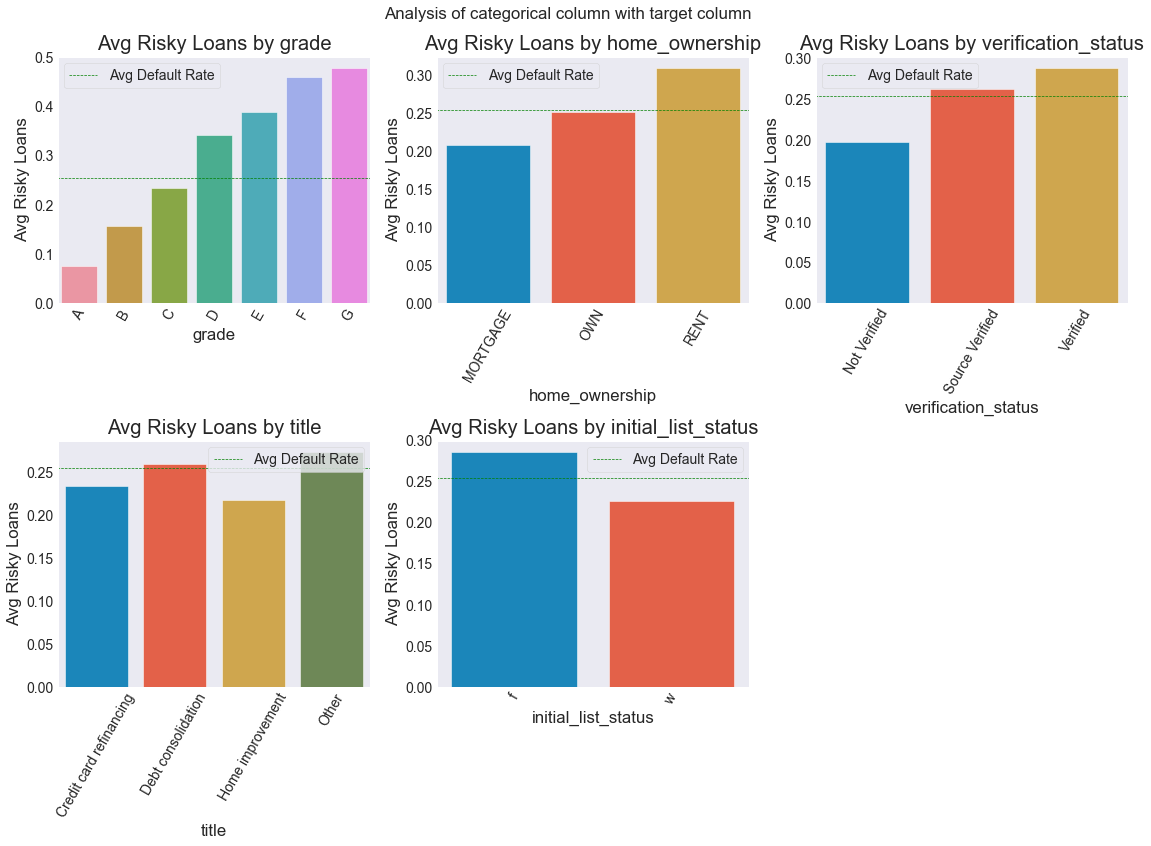

In [38]:
cat_cols = df.select_dtypes('object').columns
plt.figure(figsize=(16, 12))

for i in range(len(cat_cols)):
    plt.subplot(2, 3, i + 1)
    group = df[[cat_cols[i], 'risk']].groupby(by=cat_cols[i]).mean().sort_index()
    sns.barplot(data=group, x=group.index, y='risk')
    plt.xlabel(cat_cols[i])
    plt.ylabel('Avg Risky Loans')
    plt.title(f'Avg Risky Loans by {cat_cols[i]}')
    plt.axhline(y=avg_default_rate, label='Avg Default Rate', color='green', linestyle='--', linewidth=0.7)
    plt.xticks(rotation=60)
    plt.legend()
    
plt.suptitle('Analysis of categorical column with target column')
plt.tight_layout();

<div style="font-family: Arial; list-style-type: none; background-color: #BC5284; padding: 10px; border-radius: 10px; color: white;">
    <ul>
        <li>Loan Grades D, E and F are more vulnerable to being risky than other loans.</li>
        <li>Borrowers with Rented house are more likely to be risky than those with own/morgage home.</li>
        <li>Borrowers with initial list status w are less likely to be risky on an average.</li>
    </ul>
    </div>

In [51]:
from sklearn_extra.cluster import KMedoids

In [52]:
from sklearn.decomposition import PCA

In [54]:
df

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,title,dti,open_acc,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_rec_int,tot_cur_bal,risk
0,20000,36,12.29,C,OWN,65000.0,Source Verified,Debt consolidation,20.72,25.0,31578.0,77.0,42.0,w,0.00,0.00,52303.0,1
1,11000,36,12.69,C,MORTGAGE,40000.0,Source Verified,Debt consolidation,24.57,13.0,5084.0,38.8,41.0,w,10043.49,100.81,175731.0,1
2,7000,36,9.99,B,MORTGAGE,32000.0,Source Verified,Debt consolidation,32.41,18.0,12070.0,74.0,36.0,f,221.96,54.40,202012.0,1
3,10000,36,10.99,B,MORTGAGE,48000.0,Source Verified,Credit card refinancing,30.98,18.0,22950.0,66.0,41.0,f,315.13,79.37,108235.0,1
4,9550,36,19.99,E,RENT,32376.0,Verified,Debt consolidation,32.54,9.0,4172.0,29.6,26.0,w,333.66,137.88,45492.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421089,25000,36,20.99,E,MORTGAGE,55000.0,Verified,Debt consolidation,31.22,13.0,22438.0,63.2,18.0,f,8417.44,3546.35,167189.0,1
421090,5875,36,15.59,D,MORTGAGE,41000.0,Verified,Debt consolidation,26.70,10.0,7594.0,61.7,28.0,f,2043.52,686.57,174030.0,1
421091,10000,60,23.99,F,RENT,35000.0,Verified,Debt consolidation,8.30,6.0,4317.0,60.2,12.0,w,2577.01,1708.44,8529.0,1
421092,19600,60,14.31,C,OWN,49000.0,Verified,Credit card refinancing,22.58,22.0,93358.6,26.7,48.0,w,4064.94,1751.41,141120.0,1


# Logistic Regression

# Baseline

In [39]:
baseline = df['risk'].value_counts(normalize=True).max()
baseline

0.7453867358521161

In [40]:
X = df.drop('risk', axis=1)
y = df['risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    LogisticRegression(class_weight='balanced')
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['grade', 'home_ownership',
                                     'verification_status', 'title',
                                     'initial_list_status'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [42]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4597
           1       0.96      0.99      0.98      1570

    accuracy                           0.99      6167
   macro avg       0.98      0.99      0.99      6167
weighted avg       0.99      0.99      0.99      6167



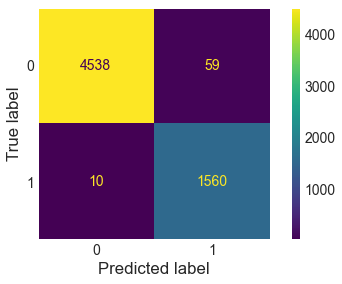

In [43]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [44]:
score = roc_auc_score(y_train, model.predict(X_train)).round(2)
score

0.99

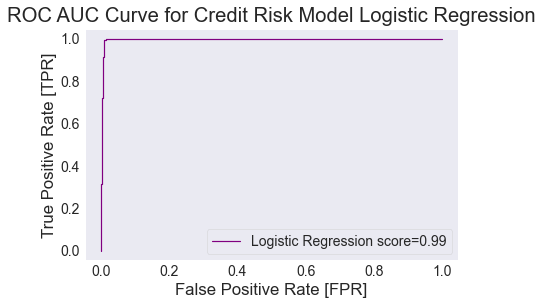

In [45]:
plot_roc_curve(model, X_test, y_test, color='purple', linewidth=1.2, label=f'Logistic Regression score={score}')
plt.title('ROC AUC Curve for Credit Risk Model Logistic Regression')
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]');

# Model Explainability

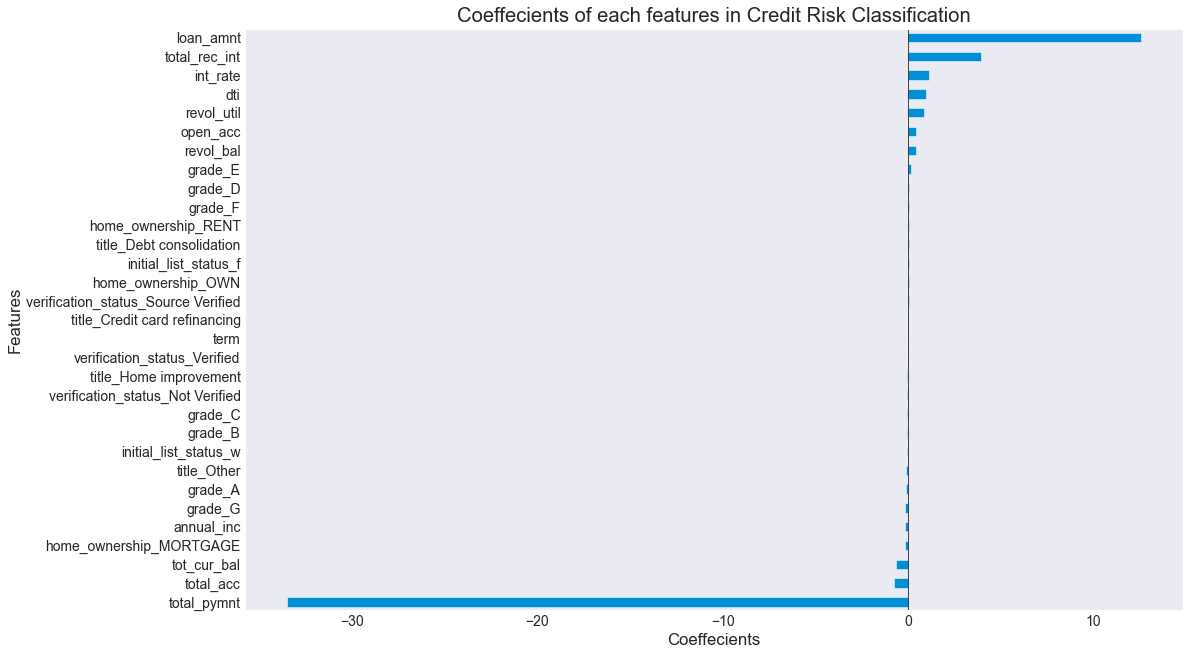

In [46]:
odds = model.named_steps['logisticregression'].coef_.flatten()
feats = model.named_steps['onehotencoder'].get_feature_names_out()
importances = pd.Series(odds, index=feats).sort_values()
plt.figure(figsize=(15, 10))
importances.plot(kind='barh')
plt.xlabel('Coeffecients')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linewidth=0.7)
plt.title('Coeffecients of each features in Credit Risk Classification');

<div style="font-family: Arial; list-style-type: none; background-color: #5285BC; padding: 10px; border-radius: 10px; color: white;">
    From the graph above, it can be clearly seen that the following variables positively impact the risk of default (in order):
    <Ol>
        <li> Loan Amount </li>
        <li> Total Rec Int </li>
        <li> Interest Rate </li>
        <li> DTI </li>
        <li> Revol Util </li>
        <li> Open Acc </li>
        <li> Revol Bal </li>
    </Ol>
     It can also be seen that the following variables negatively impact the risk of default (in order):
    <Ol>
        <li> Total Payment </li>
        <li> Total curr Bal</li>
        <li> Total Acc</li>
    </Ol>
</div>

# Deciding the Decision boundary

### Things to consider when changing the decision boundary of the classification model:
<div style="font-family: Arial; list-style-type: none; background-color: #A252BC; padding: 10px; border-radius: 10px; color: white;">
We should consider changing the boundary value of the model if the model is showing high rates of false positives or false negatives. For example, if the model is classifying many non-defaulting loans as defaults (false positives), this may be causing a high number of denied loans for otherwise creditworthy applicants. This can cause frustration and loss of business for the lender. In this case, the lender might want to change the decision boundary to be more lenient, resulting in fewer false positives and more loans being approved.

On the other hand, if the model is classifying many defaulting loans as non-defaulting loans (false negatives), this may be causing a high level of loan defaults and financial loss for the lender. In this case, the lender might want to change the decision boundary to be more strict, resulting in fewer false negatives and more defaults being identified.

It's important to note that changing the decision boundary will likely impact the overall performance of the model, so it should be done with care and after careful evaluation of the trade-offs between the different evaluation metrics. It's also important to consider the business and regulatory context in which the model will be used. And also, it's important to consider the fairness and ethical concerns when adjusting the decision boundary.
    </div>

In [47]:
@interact(decision_boundary = FloatSlider(value=0.3, min=0.3, max=0.7, step=0.02))
def widget(decision_boundary):
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    y_preds = np.array(((y_pred_proba) > decision_boundary).astype(int)).reshape(-1, 1)
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_preds, ax=ax1);
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    
    # Assumption
    loss_if_default = 100000
    profit_if_not_default = 15000
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).flatten()
    # Amount saved by finding the correct risky loans
    saved = tp * loss_if_default
    # Opportunity cost for false positive and lost amount for false negatives
    lost = fp * profit_if_not_default + fn * loss_if_default
    net = saved - lost

    ax2.text(0,0.65,f'Loss: ${lost}', fontsize=24)
    ax2.text(0,0.5,f'Saved: ${saved}', fontsize=24)
    ax2.text(0,0.35, f'Net: ${net}', fontsize=24)

interactive(children=(FloatSlider(value=0.3, description='decision_boundary', max=0.7, min=0.3, step=0.02), Ou…

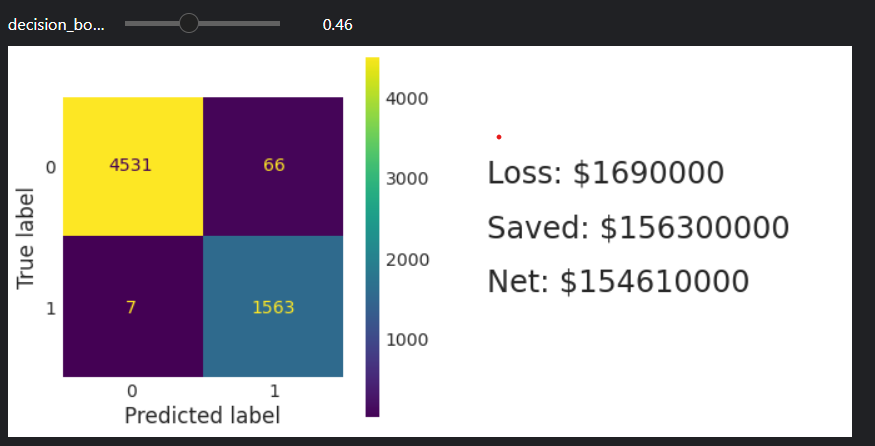

<div style="font-family: Arial; list-style-type: none; background-color: #52B7BC; padding: 10px; border-radius: 10px; color: white;">
    <p>For this problem context, I have assumed that the profit to the bank is <em> 15000 </em>if the borrower does not default and the loss to the bank if the borrower defaults to be <em> 100000 </em>. To make it simpler, I am going to select the decision boundary which brings most positive cash flow to the bank such that they can save the highest amount and earn the highest amount possible from this model. </p>
<p>
    Given the context, it can be seen from the above graph, the decision boundary of <b style="color:yellow;">0.46 </b> gives the most profit to the organization and seems to be the optimum decision boundary.</p>
    </div>

# Model Inference

In [48]:
with open('credit-risk.pkl', 'wb') as f:
    pickle.dump(model, file=f)

In [49]:
def predict(loan_amnt, term, int_rate, grade, home_ownership, annual_inc, verification_status, title, dti, 
           open_acc, revol_bal, revol_util, total_acc, initial_list_status, total_pymnt, total_rec_int, tot_cur_bal):
    
    df_dict = {
        'loan_amnt': loan_amnt,
        'term': term,
        'int_rate': int_rate,
        'grade': grade,
        'home_ownership': home_ownership,
        'annual_inc': annual_inc,
        'verification_status': verification_status,
        'title': title,
        'dti': dti,
        'open_acc': open_acc,
        'revol_bal': revol_bal,
        'revol_util': revol_util,
        'total_acc': total_acc,
        'initial_list_status': initial_list_status,
        'total_pymnt': total_pymnt,
        'total_rec_int': total_rec_int,
        'tot_cur_bal': tot_cur_bal
    }
    
    with open('credit-risk.pkl', 'rb') as f:
        mod = pickle.load(f)
        
    inp = pd.DataFrame(df_dict, index=[0])
    
    proba = round(mod.predict_proba(inp)[0][1] * 100, 2)
    
    return f'Probability of risk is {proba}'

In [50]:
predict(
    9000,
    36,
    12.69,
    'C',
    'RENT',
    65000,
    'Verified',
    'Other',
    2.62,
    5.0,
    2932.0,
    47.3,
    9.0,
    'f',
    9525.1,
    525.11,
    2932.0
)

'Probability of risk is 2.39'

# Conclusion
<div  style="font-family: Arial; list-style-type: none; background-color: #00214B; padding: 10px; border-radius: 10px; color: white;">
The credit risk modeling aimed to improve the bank's ability to predict which customers are likely to default on their loans in the future. By analyzing the loan-default and identifying which loans are likely to default in the future, the bank can take appropriate action to reduce its overall risk and increase its profitability. By utilizing statistical techniques and machine learning algorithms, we were able to analyze vast amounts of loan data and identify patterns and trends that indicate a higher likelihood of default.
 </div>